## INITIALISATION

### IMPORTS

In [1]:
import ollama
import numpy as np
import pandas as pd
import os
import time
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

FRENCH = False

### GLOBAL VARIABLES

In [2]:
action_df = pd.read_csv("df_csv/action_dataset.csv", header=0, sep=";").dropna(how='all')
with open('french_stop_words.txt', 'r') as f:
    STOP_WORDS = f.read().splitlines()

MODEL_NAME = 'qwen:4b'
ACTION_LABELS = action_df['action'].dropna().unique()
TEST_SENTENCES = action_df['assistant_sentence']
TEST_WORDS = None
N_DIM = 50

### FUNCTIONS

In [3]:
def embedding_func(text: str) -> np.ndarray:
    return np.array(ollama.embeddings(model=MODEL_NAME, prompt=text)['embedding'])

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_save_embeddings(file_name: str, text_iterable: list):
    if os.path.exists(file_name):
        with open(file_name, 'rb') as f:
            embeddings = np.load(f)
    else:
        embeddings = np.array([embedding_func(sentence) for sentence in tqdm(text_iterable)])
        # save the embeddings
        with open(file_name, 'wb') as f:
            np.save(f, embeddings)
    
    return embeddings

def extract_vocabulary(text_iterable: list, stop_words: list = STOP_WORDS):
    if stop_words is None:
        stop_words = []
    vocabulary = set()
    for text in text_iterable:
        words = text.split()
        for word in words:
            if word not in stop_words:
                vocabulary.add(word)
    return vocabulary

def new_words(text:str, stop_words: list = STOP_WORDS) -> list:
    chars_to_replace_with_space = ['?', '!', '.', ',', ';', "'", '"']
    words = text.lower()
    for char in chars_to_replace_with_space:
        words = words.replace(char, ' ')
    words = words.split()
    return extract_vocabulary(words, stop_words)

def new_phrase(text:str, stop_words: list = STOP_WORDS) -> str:
    return ' '.join(new_words(text, stop_words))

def print_bad_predictions(y_test, y_pred, X_test, X):
    # print all bad predictions, sentence and label
    print("SHAPES", "-"*50)
    print(f"y_test: {y_test.shape}")
    print(f"y_pred: {y_pred.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"X: {X.shape}")
    print("\nBAD PREDICTIONS", "-"*50)
    print("Sentence - True Label - Predicted Label")
    for i in range(len(y_pred)):
        if y_pred[i] != y_test.iloc[i]:
            # find index in X_pca where X_test[i] is
            try :
                index = np.where((X == X_test[i]).all(axis=1))[0][0]
                print(f"-  {TEST_SENTENCES.iloc[index]} - {y_test.iloc[i]} - {y_pred[i]}")
            except:
                print(f"Index {i} not found in X_pca, y_pred={y_test.iloc[i]}, y_test={y_pred[i]}")

def encode_y(y_str, dict_str_int):
    return np.array([dict_str_int[label] for label in y_str])

def decode_y(y_int, dict_int_str):
    return np.array([dict_int_str[label] for label in y_int])

In [4]:
print(embedding_func('The quick brown fox jumps over the lazy fog')) # test embedding function so the model is loaded

print(TEST_SENTENCES[0])
print(new_phrase(TEST_SENTENCES[0]))

[ 1.36302388 -6.48960733  1.58267856 ... -5.59257698 -4.16055059
 -7.75819683]
Je vais t'envoyer ces informations par mail.
informations mail vais envoyer


In [5]:
# action df label count
print(action_df['action'].value_counts())
# action df no action count
print(action_df['action'].isna().sum())

action
Dire au revoir                         258
Envoyer un mail                        256
Recommander une personne compétente    253
Se réidentifier                        160
Name: count, dtype: int64
1000


In [6]:
sentences_words = TEST_SENTENCES.apply(new_words)
# count = {i : len(sentences_words[i]) for i in range(len(sentences_words))}

count = 0
dict_senteces_word_indexes = dict()
for i in range(len(sentences_words)):
    for j in range(len(sentences_words[i])):
        dict_senteces_word_indexes[count] = (i, j)
        count += 1

TEST_WORDS = np.array([word for words in sentences_words for word in words])

##### plot

In [7]:
def break_sentence_into_lines(sentence: str, max_line_length: int = 20) -> str:
    words = sentence.split()
    lines = []
    line = ''
    for word in words:
        if len(line) + len(word) + 1 <= max_line_length:
            line += word + ' '
        else:
            lines.append(line)
            line = word + ' '
    lines.append(line)
    return '\n'.join(lines)

def pretty_print_matrix(matrix: np.ndarray, num_spaces: int = 2):
    for row in matrix:
        for cell in row:
            if round(cell, 2) == 0:
                print('0   ', end=' ' * num_spaces)
            else:
                print(f'{cell:.2f}', end=' ' * num_spaces)
        print()

# plot the t-SNE
def plot_2D(X, ax, legend=False):
    cmap = plt.colormaps.get_cmap('tab10')
    names = []
    for i, action_label in enumerate(ACTION_LABELS):

        mask = action_df['action'] == action_label
        ax.scatter(X[mask, 0], X[mask, 1], alpha=0.7, label=action_label, color=cmap(i), s=12)

        x_mean = X[mask, 0].mean()
        y_mean = X[mask, 1].mean()
        name_str = break_sentence_into_lines(" ".join(action_label.split("_")).title(), max_line_length=20)
        
        names.append(name_str)
        if not legend:
            ax.text(x_mean, y_mean, name_str, horizontalalignment='center', verticalalignment='center', fontsize=8, fontstyle='italic', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4), color=cmap(i))

    if legend:
        ax.legend(names)
    # other data (action_label not in the list)
    mask = ~action_df['action'].isin(ACTION_LABELS)
    ax.scatter(X[mask, 0], X[mask, 1], alpha=0.7, label="other", color='grey', s=10)


def plot_confusion_matrix(y, y_pred, labels):

    c_matrix = np.array(confusion_matrix(y, y_pred, labels=labels))

    fig, ax = plt.subplots()
    cmap = plt.colormaps.get('Blues')
    cax = ax.matshow(c_matrix, cmap=cmap)
    max_val = c_matrix.max()
    min_val = c_matrix.min()
    # text
    for (i, j), val in np.ndenumerate(c_matrix):
        if val == min_val:
            continue
        bg_color = cmap((val - min_val) / (max_val - min_val))
        luminance = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
        text_color = 'black' if luminance > 0.5 else 'white'
        ax.text(j, i, f"{val}", ha='center', va='center', color=text_color)

    # insert \n in labels when too long
    each_n = 24

    def insert_newlines(string, every=30):
        words = string.split()
        # if the combined length of the words is less than the every parameter
        if len(' '.join(words)) < every:
            return ' '.join(words)
        
        # if the combined length of the words is greater than the every parameter
        new_string = ''
        current_length = 0
        for word in words:
            if current_length + len(word) > every:
                new_string += '\n'
                current_length = 0
            new_string += word + ' '
            current_length += len(word) + 1
        return new_string

    plt_labels = [labels[i] if len(labels[i]) < each_n else insert_newlines(labels[i], each_n) for i in range(len(labels))]
    if FRENCH:
        plt_labels = ['Inconnu' if label == 'Unknown' else label for label in plt_labels]

    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    plt.xticks(range(len(labels)), range(len(labels)))
    plt.yticks(range(len(labels)), range(len(labels)))

    # text associating label number with label name
    for i in range(len(labels)):
        ax.text(len(labels), i, f"{i} - {plt_labels[i]}", ha='left', va='center', fontsize=10)

    ax.xaxis.set_label_position('top') 
    if FRENCH:
        plt.title('Matrice de confusion', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
        plt.xlabel('Action prédite')
        plt.ylabel('Action réelle')
    else:
        plt.title('Confusion matrix', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
        plt.xlabel('Predicted action')
        plt.ylabel('Actual action')
    plt.tight_layout()
    plt.show()

## COMPUTE EMBEDDINGS

In [8]:
action_embeddings = get_save_embeddings(f"embeddings/action_embeddings_{MODEL_NAME}.npy", ACTION_LABELS)

100%|██████████| 4/4 [00:00<00:00, 20.81it/s]


In [9]:
test_sentence_embeddings = get_save_embeddings(f"embeddings/test_sentence_embeddings_{MODEL_NAME}.npy", TEST_SENTENCES)

100%|██████████| 1927/1927 [00:55<00:00, 34.75it/s]


In [10]:
test_word_embeddings = get_save_embeddings(f"embeddings/test_word_embeddings_{MODEL_NAME}.npy", TEST_WORDS)

100%|██████████| 9536/9536 [03:48<00:00, 41.69it/s]


## COMPUTE PCA and TSNE

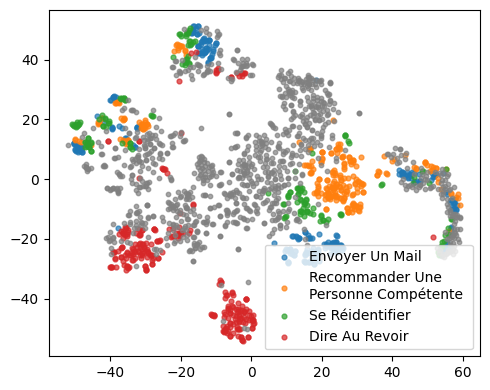

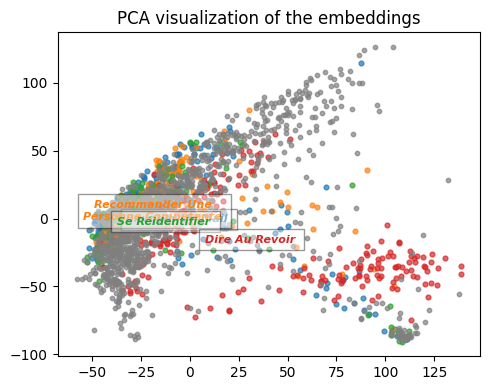

In [11]:
# tsne visualization of the embeddings

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(test_sentence_embeddings)

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(test_sentence_embeddings)


fig, ax = plt.subplots(figsize=(5, 4))
plot_2D(X_tsne, ax, legend=True)
# ax.set_title("t-SNE visualization of the embeddings")
plt.tight_layout()
plt.savefig("plots/tsne.png", dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(5, 4))
plot_2D(X_pca, ax)
ax.set_title("PCA visualization of the embeddings")
plt.tight_layout()
plt.savefig("plots/pca.png", dpi=300, bbox_inches='tight')
plt.show()


## CLASSIFICATION

### PREPROCESSING

In [25]:
test_sentence_similarity_file_name = f"embeddings/test_sentence_similarity_{MODEL_NAME}.npy"

if os.path.exists(test_sentence_similarity_file_name):
    with open(test_sentence_similarity_file_name, 'rb') as f:
        test_sentence_similarity = np.load(f)
else:
    test_sentence_similarity = np.array([[cosine_similarity(action_embedding, test_sentence_embedding) for test_sentence_embedding in test_sentence_embeddings] for action_embedding in action_embeddings])
    with open(test_sentence_similarity_file_name, 'wb') as f:
        np.save(f, test_sentence_similarity)

In [26]:
ponctuation_features = np.array([[(p in sentence) for p in ['.', ',', '?', '!']] for sentence in TEST_SENTENCES]).astype(float)

In [27]:
word_in_action_features = np.array([[np.mean([1 if (word in action) else 0 for word in words]) for action in ACTION_LABELS] for words in sentences_words]).astype(float)

C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(test_sentence_embeddings)

pca = PCA(n_components=N_DIM, random_state=0)
X_pca = pca.fit_transform(test_sentence_embeddings)

In [29]:
print("SHAPES", "="*35)
print("  X_tsne                     ", X_tsne.shape)
print("  X_pca                      ", X_pca.shape)
print("  action_embeddings          ", action_embeddings.shape)
print("  test_sentence_embeddings   ", test_sentence_embeddings.shape)
print("  test_sentence_similarity   ", test_sentence_similarity.shape)
print("  ponctuation_features       ", ponctuation_features.shape)
print("  word_in_action_features    ", word_in_action_features.shape)

SHAPES ===================================
  X_tsne                      (1927, 3)
  X_pca                       (1927, 50)
  action_embeddings           (4, 2560)
  test_sentence_embeddings    (1927, 2560)
  test_sentence_similarity    (4, 1927)
  ponctuation_features        (1927, 4)
  word_in_action_features     (1927, 4)


In [32]:
X = np.concatenate([X_pca, test_sentence_similarity.T, word_in_action_features], axis=1) # [X_pca, test_sentence_similarity.T, word_in_action_features]
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_str = action_df['action']
# if y not in ACTION_LABELS, replace it with "Unknown"
# y = y.apply(lambda x: x if x in ACTION_LABELS else "Unknown")
y_str = y_str.fillna("Unknown")
y_str_unique = np.concatenate([ACTION_LABELS, ["Unknown"]])
dict_str_num = {label: i for i, label in enumerate(y_str_unique)}
dict_num_str = {i: label for i, label in enumerate(y_str_unique)}

X_train, X_test, y_train, y_test = train_test_split(X, y_str, test_size=0.2, random_state=0)

print("SHAPES", "="*15)
print("  X_train ", X_train.shape)
print("  X_test  ", X_test.shape)
print("  y_train ", y_train.shape)
print("  y_test  ", y_test.shape)

SHAPES ===============
  X_train  (1541, 58)
  X_test   (386, 58)
  y_train  (1541,)
  y_test   (386,)


### SIMILARITY

#### sentence to action

Time to predict: 0.00100s
Accuracy: 0.19
F1 score: 0.139


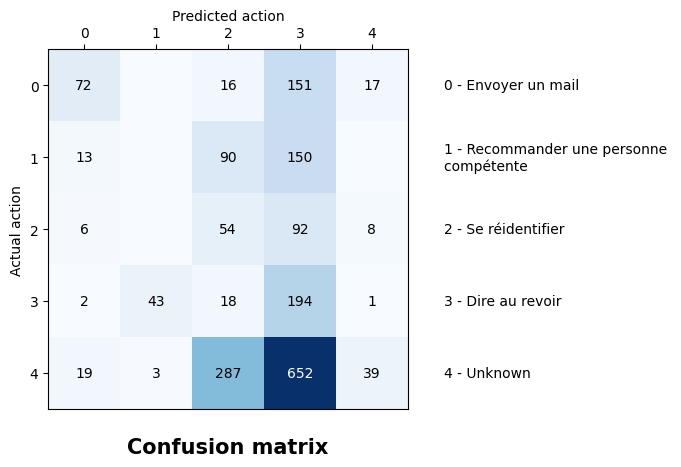

SHAPES --------------------------------------------------
y_test: (1927,)
y_pred: (1927,)
X_test: (1927, 2560)
X: (1927, 2560)

BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  Je t'enverrai un e-mail avec les détails. - Envoyer un mail - Dire au revoir
-  Tu recevras ces infos par courrier électronique. - Envoyer un mail - Se réidentifier
-  Je vais t'envoyer un courriel avec les données. - Envoyer un mail - Dire au revoir
-  Prépare-toi à recevoir un message électronique de ma part. - Envoyer un mail - Unknown
-  Je t'adresse un mail avec les informations nécessaires. - Envoyer un mail - Se réidentifier
-  Tu auras ces infos par e-mail très bientôt. - Envoyer un mail - Unknown
-  Je vais t'envoyer ces détails par message électronique. - Envoyer un mail - Dire au revoir
-  Je t'envoie les informations via e-mail. - Envoyer un mail - Dire au revoir
-  Tu recevras un courriel avec ces informations. - Envoyer un mail - Dire au 

In [18]:
t0 = time.time()
y_pred = np.array(np.argmax(test_sentence_similarity, axis=0))
# when similarity under threshold, predict y_pred = 0
threshold = 0.4
y_pred[np.max(test_sentence_similarity, axis=0) < threshold] = dict_str_num['Unknown']
y_pred_str = decode_y(y_pred, dict_num_str)
t1 = time.time()
print(f"Time to predict: {(t1-t0):.5f}s")

accuracy = (y_str == y_pred_str).mean()
print(f"Accuracy: {accuracy:.2f}")

f1 = f1_score(y_str, y_pred_str, average='weighted')
print(f"F1 score: {f1:.3f}")

# plot confusion matrix
plot_confusion_matrix(y_str, y_pred_str, y_str_unique)

# print bad predictions
print_bad_predictions(y_str, y_pred_str, X, X)

#### word to action

In [19]:
test_word_similarity_file_name = f"embeddings/test_word_similarity_{MODEL_NAME}.npy"

if os.path.exists(test_word_similarity_file_name):
    with open(test_word_similarity_file_name, 'rb') as f:
        test_word_similarity = np.load(f)
else:
    test_word_similarity = np.zeros((len(TEST_WORDS), len(ACTION_LABELS)))
    for i, word_embedding in tqdm(enumerate(test_word_embeddings)):
        for j, action_embedding in enumerate(action_embeddings):
            test_word_similarity[i, j] = cosine_similarity(word_embedding, action_embedding)
        
    with open(test_word_similarity_file_name, 'wb') as f:
        np.save(f, test_word_similarity)

9536it [00:00, 29044.60it/s]


100%|██████████| 9536/9536 [00:00<00:00, 190766.57it/s]

Time to predict: 0.04999s
Accuracy: 0.11
F1: 0.065


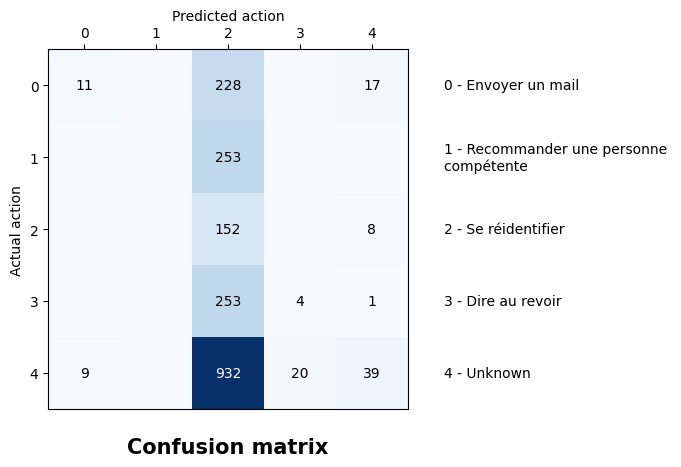

SHAPES --------------------------------------------------
y_test: (1927,)
y_pred: (1927,)
X_test: (1927, 2560)
X: (1927, 2560)

BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  Je vais t'envoyer ces informations par mail. - Envoyer un mail - Se réidentifier
-  Je t'enverrai un e-mail avec les détails. - Envoyer un mail - Se réidentifier
-  Tu recevras ces infos par courrier électronique. - Envoyer un mail - Se réidentifier
-  Je vais t'envoyer un courriel avec les données. - Envoyer un mail - Se réidentifier
-  Je te fais suivre ça par e-mail. - Envoyer un mail - Se réidentifier
-  Je t'enverrai ces informations par courriel. - Envoyer un mail - Se réidentifier
-  Prépare-toi à recevoir un message électronique de ma part. - Envoyer un mail - Unknown
-  Je t'adresse un mail avec les informations nécessaires. - Envoyer un mail - Se réidentifier
-  Je vais te transmettre les détails par e-mail. - Envoyer un mail - Se réidentifie

In [20]:
# now we have the similarity between each word and each action
# we can sum the similarities of all the words in a sentence to get the similarity between the sentence and the action
t0 = time.time()
test_sentence_similarity_sum = np.zeros((len(TEST_SENTENCES), len(ACTION_LABELS)))
for n_word, (n_sentence, n_word_in_sentence) in tqdm(dict_senteces_word_indexes.items()):
    test_sentence_similarity_sum[n_sentence] += test_word_similarity[n_word] / len(sentences_words[n_sentence])

y_pred = np.array(np.argmax(test_sentence_similarity_sum, axis=1))
threshold = 0.4
y_pred[np.max(test_sentence_similarity, axis=0) < threshold] = dict_str_num['Unknown']
y_pred_str = decode_y(y_pred, dict_num_str)
t1 = time.time()
print(f"Time to predict: {(t1-t0):.5f}s")

accuracy = (y_str == y_pred_str).mean()
print(f"Accuracy: {accuracy:.2f}")

f1 = f1_score(y_str, y_pred_str, average='weighted')
print(f"F1: {f1:.3f}")

# plot confusion matrix
plot_confusion_matrix(y_str, y_pred_str, y_str_unique)

# print bad predictions
print_bad_predictions(y_str, y_pred_str, X, X)

### RANDOM FOREST

Time to predict: 0.00215s
Training accuracy: 1.0
Test accuracy: 0.9119170984455959
F1: 0.910


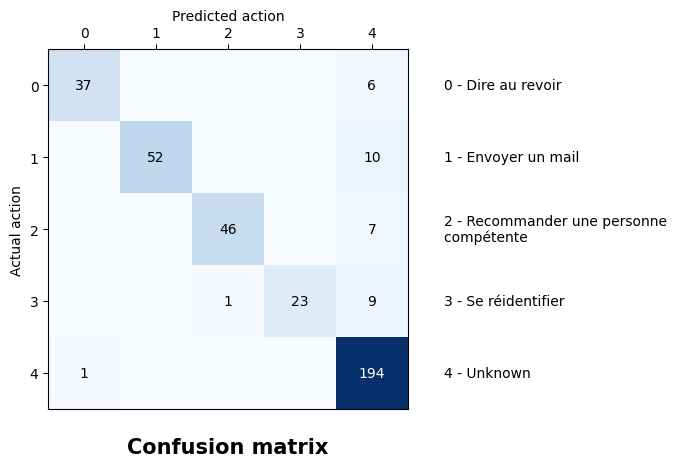

SHAPES --------------------------------------------------
y_test: (386,)
y_pred: (386,)
X_test: (386, 58)
X: (1927, 58)

BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  À plus tard ? - Dire au revoir - Unknown
-  Vérification de ton identité en cours. - Se réidentifier - Unknown
-  Je vais t'introduire à la personne idéale pour t'aider. - Recommander une personne compétente - Unknown
-  Je vais te transmettre un e-mail dans les instants qui suivent. - Envoyer un mail - Unknown
-  Dois-je relancer la reconnaissance de ton identité ? - Se réidentifier - Unknown
-  La prochaine fois, on se retrouve pour de nouvelles aventures ? - Dire au revoir - Unknown
-  Je relance la vérification pour plus de certitude. - Se réidentifier - Unknown
-  Lançons la réidentification. - Se réidentifier - Unknown
-  Je vais veiller à ce que tu sois mis en relation avec le spécialiste approprié. - Recommander une personne compétente - Unknown
-  Al

In [33]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
t0 = time.time()
transformation_test = pca.transform(test_sentence_embeddings[1].reshape(1, -1))
# y_proba = clf.predict_proba(X_test)

y_pred = clf.predict(X_test)
t1 = time.time()
# y_pred = np.array([y_pred[i] if y_proba[i, clf.classes_ == y_pred[i]] > 0.0 else 'Unknown' for i in range(len(y_pred))])

print(f"Time to predict: {(t1-t0):.5f}s")
test_accuracy = np.mean(y_pred == y_test)

print(f"Training accuracy: {clf.score(X_train, y_train)}")
print(f"Test accuracy: {test_accuracy}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1: {f1:.3f}")

plot_confusion_matrix(y_test, y_pred, clf.classes_)

print_bad_predictions(y_test, y_pred, X_test, X)

### NEURAL NETWORK

C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │        40,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,333 (161.46 KB)

 Trainable params: 41,333 (161.46 KB)

 Non-trainable params: 0 (0.00 B)

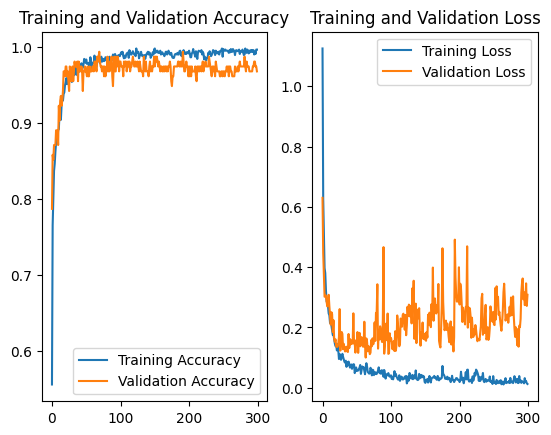

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0       0       0       1.00    0       
0       0       0       0       1.00    
1.00    0       0       0       0       
0       0       0       1.00    0       
0       1.00    0       0       0       
0       0       0       0       1.00    
0       0       0       0       1.00    
0       0       0       0       1.00    
1.00    0       0       0       0       
1.00    0       0       0       0       
0       0       0       0       1.00    
0       0       0       1.00    0       
1.00    0       0       0       0       
1.00    0       0       0       0       
0       0       1.00    0       0       
0       0       0       0       1.00    
0       0       0       0       1.00    
1.00    0       0       0       0       
0       0       0       1.00    0       
0       0       0       1.00    0       
0       0       0       0       1.00    
0       0.15    0.85    0       0       
1.00    0       0       0       0       
0       0       0

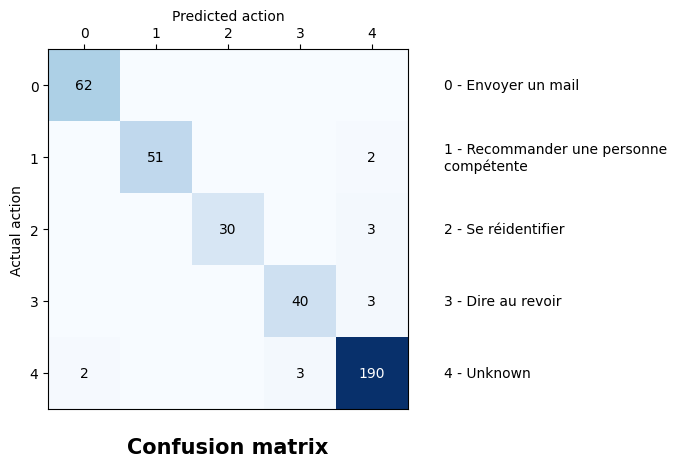

SHAPES --------------------------------------------------
y_test: (386,)
y_pred: (386,)
X_test: (386, 2560)
X: (1927, 2560)

BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  À oui ? - Unknown - Dire au revoir
-  La prochaine fois, on se retrouve pour de nouvelles aventures ? - Dire au revoir - Unknown
-  Allons dénicher le cerveau le plus brillant de notre organisation pour résoudre ce problème. - Recommander une personne compétente - Unknown
-  Que cette séparation soit légère et courte - Dire au revoir - Unknown
-  Au revoir, et fais attention ! - Dire au revoir - Unknown
-  Redémarrons le processus d'identification. - Se réidentifier - Unknown
-  Allez-y tapez votre code. - Unknown - Envoyer un mail
-  À la tienne ! - Unknown - Dire au revoir
-  Désolé, il semble que je me sois trompé, je vais voir si je peux te reconnaître à nouveau. - Se réidentifier - Unknown
-  Allons chercher l'as de notre entreprise pour résoudre ce 

In [22]:
num_classes = len(y_str_unique)

model = Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

y_train_int = encode_y(y_train, dict_str_num)

epochs = 300
history = model.fit(X_train, y_train_int, epochs=epochs, validation_split=0.1, verbose=0)



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





y_pred_probas = model.predict(X_test)
# argmax if proba above threshold, else 'Unknown' (-100)
pretty_print_matrix(y_pred_probas, num_spaces=4)
y_pred_int = np.array([np.argmax(probas) if np.max(probas) > 0.3 else dict_str_num["Unknown"] for probas in y_pred_probas])
y_pred = decode_y(y_pred_int, dict_num_str)

test_accuracy = np.mean(y_pred == y_test)
print(f"Test accuracy: {test_accuracy}")

plot_confusion_matrix(y_test, y_pred, y_str_unique)

print_bad_predictions(y_test, y_pred, X_test, X)

In [23]:
# save the model
model.save(f"models/{MODEL_NAME}_model.h5")

## INFERENCE

In [24]:
# load the model
model = tf.keras.models.load_model(f"models/{MODEL_NAME}_model.h5")

# inference
sentence = "Parler"
sentence_embedding_large = embedding_func(sentence)
sentence_similarity = np.array([cosine_similarity(sentence_embedding_large, action_embedding) for action_embedding in action_embeddings]).reshape(1, -1)
sentence_embedding = pca.transform(sentence_embedding_large.reshape(1, -1))
ponctuation_features = np.array([[(p in sentence) for p in ['.', ',', '?', '!']]]).astype(float)
words = new_words(sentence)
word_in_action_features = np.array([[np.mean([1 if (word in action) else 0 for word in words]) for action in ACTION_LABELS]]).astype(float)

X = np.concatenate([sentence_embedding, sentence_similarity, word_in_action_features], axis=1)
X = scaler.transform(X)
y_proba = model.predict(X)
y_str = decode_y(np.argmax(y_proba, axis=1), dict_num_str)[0]
print("Action probas")
pretty_print_matrix(y_proba, num_spaces=4)
print(f"Sentence: {sentence}")
print(f"Action: {y_str}")

ValueError: X has 58 features, but StandardScaler is expecting 2560 features as input.